In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import lightgbm as lgb

from batchflow import Pipeline, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel, VGGBlock
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from loader import ImagesDataset

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)

100%|█████████████████████████████████████████████| 9/9 [00:18<00:00,  2.01s/it]


In [5]:
MODEL_PATH = '../models/vgg.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

## 

In [6]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('images', 'labels', 'proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predictions', 'predicted_proba'], save_to=[B('predictions'), B('proba')])
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)

CPU times: user 814 ms, sys: 993 ms, total: 1.81 s
Wall time: 8.64 s


In [7]:
%%time

n_features = 10
pca = PCA(n_components=n_features, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)
train_data = lgb.Dataset(data=train_features_reduced, label=train_batch.labels)

CPU times: user 1min 51s, sys: 1min 12s, total: 3min 4s
Wall time: 4.96 s


In [15]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)
test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)
test_data = lgb.Dataset(data=test_features_reduced, label=test_batch.labels)

CPU times: user 1.9 s, sys: 1.08 s, total: 2.97 s
Wall time: 1.03 s


In [17]:
train_config = {
    'num_leaves': 31,
    'objective': 'multiclass',
    'num_class': n_classes
}

num_round = 10

booster = lgb.train(
    params=train_config,
    train_set=train_data,
    num_boost_round=num_round,
    valid_sets=[test_data]
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1138, number of used features: 10
[LightGBM] [Info] Start training from score -3.066736
[LightGBM] [Info] Start training from score -1.356855
[LightGBM] [Info] Start training from score -1.769169
[LightGBM] [Info] Start training from score -1.955623
[LightGBM] [Info] Start training from score -1.883736
[LightGBM] [Info] Start training from score -2.452060
[LightGBM] [Info] Start training from score -3.011676
[LightGBM] [Info] Start training from score -2.336547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [18]:
prediction = booster.predict(test_features_reduced)
predicted_labels = prediction.argmax(axis=1)

In [19]:
from batchflow.models.metrics import ClassificationMetrics

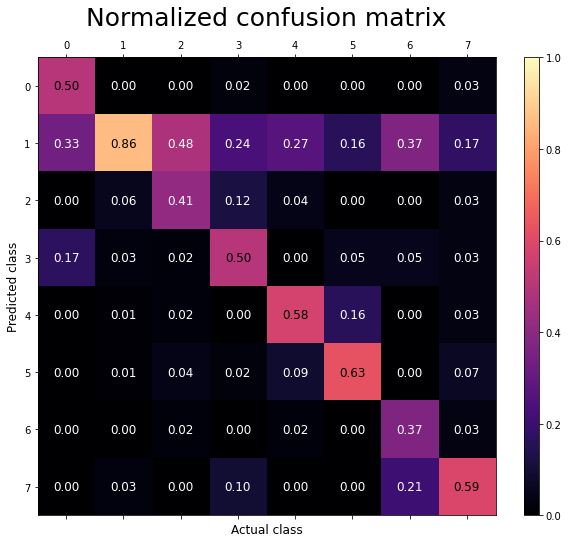

In [21]:
metrics = ClassificationMetrics(test_batch.labels, predicted_labels, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [22]:
labels, counts = np.unique(dataset.labels[dataset.test.indices], return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=metrics_names)

,names,counts,shares,precision,recall
0,ArtDeco,12,0.042254,75%,50%
1,Cubism,72,0.253521,49%,86%
2,Impressionism,46,0.161972,61%,41%
3,Japonism,42,0.147887,72%,50%
4,Naturalism,45,0.158451,81%,57%
5,Rococo,19,0.066901,54%,63%
6,cartoon,19,0.066901,70%,36%
7,photo,29,0.102113,62%,58%


In [23]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,59%,60%


In [24]:
METRICS_PATH = '../metrics/lgbm.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
np.save(METRICS_PATH, all_metrics)

In [ ]:
# labels = dataset.label_encoder.inverse_transform(batch.labels)
# for cluster_num in range(n_classes):
#     cluster_images = batch.images[clustered == cluster_num]
#     cluster_images = list(cluster_images.transpose(0, 2, 3, 1))
#     cluster_true_labels = labels[clustered == cluster_num].tolist()
#     plot(cluster_images, title=cluster_true_labels, suptitle=f"cluster: {cluster_num}", suptitle_y=1, suptitle_size=30, combine='separate')